In [1]:
#pip install modAL

In [2]:
# This example cames from the modAL library documentation accessed on January the 27th of 2022 following this link:
#https://modal-python.readthedocs.io/en/latest/content/examples/pool-based_sampling.html

In [3]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import load_iris
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from modAL.models import ActiveLearner

[[5.1 3.5 1.4 0.2]
 [4.9 3.  1.4 0.2]
 [4.7 3.2 1.3 0.2]
 [4.6 3.1 1.5 0.2]
 [5.  3.6 1.4 0.2]]


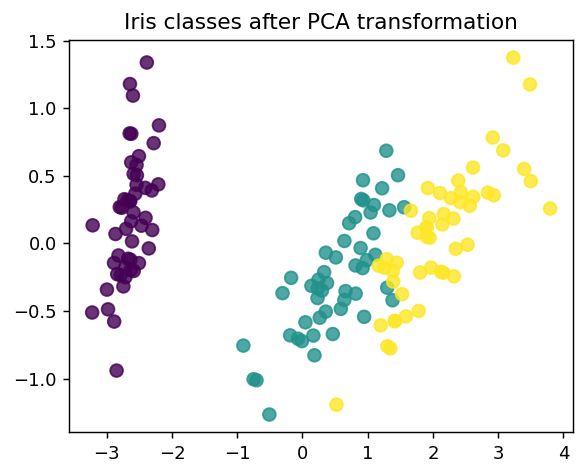

In [4]:
# Set our RNG seed for reproducibility.
RANDOM_STATE_SEED = 123
np.random.seed(RANDOM_STATE_SEED)

#Load the data
iris = load_iris()
X_raw = iris['data']
y_raw = iris['target']
print(X_raw[0:5])

# Define our PCA transformer and fit it onto our raw dataset.
pca = PCA(n_components=2, random_state=RANDOM_STATE_SEED)
transformed_iris = pca.fit_transform(X=X_raw)

# Isolate the data we'll need for plotting.
x_component, y_component = transformed_iris[:, 0], transformed_iris[:, 1]

# Plot our dimensionality-reduced (via PCA) dataset.
plt.figure(figsize=(5, 4), dpi=130)
plt.scatter(x=x_component, y=y_component, c=y_raw, cmap='viridis', s=50, alpha=8/10)
plt.title('Iris classes after PCA transformation')
plt.show()

In [5]:
X_raw.shape

(150, 4)

### Creating the pool and the training sets
Now we partition our iris dataset into a training set L and U. We first specify our training set L consisting of 3 random examples. The remaining examples go to our “unlabeled” pool U.

In [6]:
# Isolate our examples for our labeled dataset.
n_labeled_examples = X_raw.shape[0] #number of rows
#select randomly the point's indexes that are gonna be used for training
training_indices = np.random.randint(low=0, high=n_labeled_examples + 1, size=3)

X_train = X_raw[training_indices]
y_train = y_raw[training_indices]

# Isolate the non-training examples we'll be querying.
X_pool = np.delete(X_raw, training_indices, axis=0)
y_pool = np.delete(y_raw, training_indices, axis=0)

In [7]:
# Specify our core estimator along with it's active learning model.
knn = KNeighborsClassifier(n_neighbors=3)
learner = ActiveLearner(estimator=knn, X_training=X_train, y_training=y_train)

# Isolate the data we'll need for plotting.
predictions = learner.predict(X_raw) #test the learner in the complete dataset
is_correct = (predictions == y_raw) #check its performance

print(is_correct)

[False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True]


For more info go to https://modal-python.readthedocs.io/en/latest/content/models/ActiveLearner.html
The available built-in query strategies are max uncertainty sampling, max margin sampling and entropy sampling. For more details, see the Uncertainty-sampling page.
Also, this one: https://modal-python.readthedocs.io/en/latest/_modules/index.html

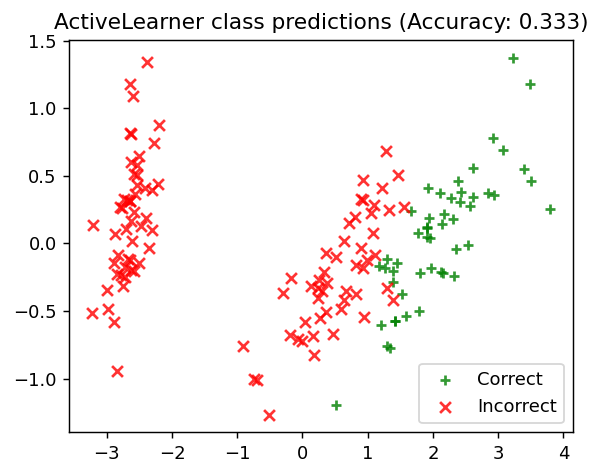

In [8]:
# Record our learner's score on the raw data.
unqueried_score = learner.score(X_raw, y_raw)

# Plot our classification results.
fig, ax = plt.subplots(figsize=(5,4), dpi=130)
ax.scatter(x=x_component[is_correct],  y=y_component[is_correct],  c='g', marker='+', label='Correct',   alpha=8/10)
ax.scatter(x=x_component[~is_correct], y=y_component[~is_correct], c='r', marker='x', label='Incorrect', alpha=8/10)
ax.legend(loc='lower right')
ax.set_title("ActiveLearner class predictions (Accuracy: {score:.3f})".format(score=unqueried_score))
plt.show()

### Introduce Active learning
Now, we tune our classifier by allowing it to query 20 instances it hasn’t seen before. Using uncertainty sampling

In [9]:
N_QUERIES = 50
performance_history = [unqueried_score]

# Allow our model to query our unlabeled dataset for the most
# informative points according to our query strategy (uncertainty sampling).
for index in range(N_QUERIES):
  query_index, query_instance = learner.query(X_pool)

  # Teach our ActiveLearner model the record it has requested.
  X, y = X_pool[query_index].reshape(1, -1), y_pool[query_index].reshape(1, )
  learner.teach(X=X, y=y)

  # Remove the queried instance from the unlabeled pool.
  X_pool, y_pool = np.delete(X_pool, query_index, axis=0), np.delete(y_pool, query_index)

  # Calculate and report our model's accuracy.
  model_accuracy = learner.score(X_raw, y_raw)
  print('Accuracy after query {n}: {acc:0.4f}'.format(n=index + 1, acc=model_accuracy))

  # Save our model's performance for plotting.
  performance_history.append(model_accuracy)

Accuracy after query 1: 0.6667
Accuracy after query 2: 0.6667
Accuracy after query 3: 0.8800
Accuracy after query 4: 0.8800
Accuracy after query 5: 0.8733
Accuracy after query 6: 0.8400
Accuracy after query 7: 0.7400
Accuracy after query 8: 0.7267
Accuracy after query 9: 0.7267
Accuracy after query 10: 0.7267
Accuracy after query 11: 0.7267
Accuracy after query 12: 0.7267
Accuracy after query 13: 0.7267
Accuracy after query 14: 0.7267
Accuracy after query 15: 0.7200
Accuracy after query 16: 0.8400
Accuracy after query 17: 0.8800
Accuracy after query 18: 0.8933
Accuracy after query 19: 0.9267
Accuracy after query 20: 0.9267
Accuracy after query 21: 0.9267
Accuracy after query 22: 0.9067
Accuracy after query 23: 0.9400
Accuracy after query 24: 0.9467
Accuracy after query 25: 0.9467
Accuracy after query 26: 0.9467
Accuracy after query 27: 0.9467
Accuracy after query 28: 0.9467
Accuracy after query 29: 0.9667
Accuracy after query 30: 0.9733
Accuracy after query 31: 0.9733
Accuracy after qu

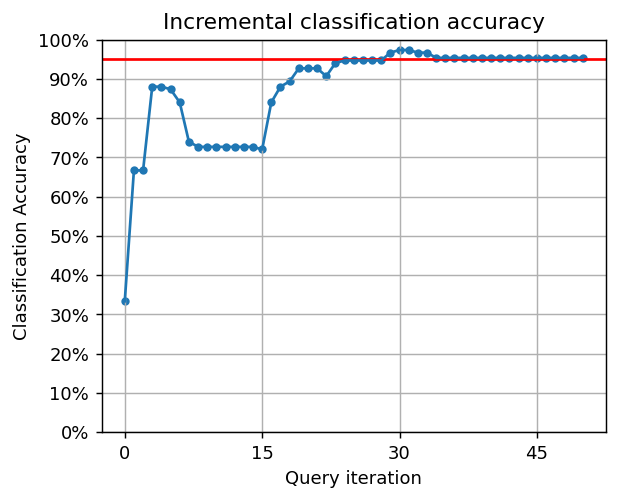

In [10]:
# Plot our performance over time.
fig, ax = plt.subplots(figsize=(5,4), dpi=130)

ax.axhline(y=.95, xmin=0, xmax=20, color='r', linestyle='-', linewidth=1.5)
ax.plot(performance_history)
ax.scatter(range(len(performance_history)), performance_history, s=13)

ax.xaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=5, integer=True))
ax.yaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=10))
ax.yaxis.set_major_formatter(mpl.ticker.PercentFormatter(xmax=1))

ax.set_ylim(bottom=0, top=1)
ax.grid(True)

ax.set_title('Incremental classification accuracy')
ax.set_xlabel('Query iteration')
ax.set_ylabel('Classification Accuracy')

plt.show()

As we can see in the previous figure, there is a point when the accuracy reaches a steady state so no more trainin is needed, that is, no more labels need to be queried so that we save resources. 

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 1 1 1 1 1 2 1 2 1
 1 1 1 1 1 1 1 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 1 2 2 2 2
 2 2 2 2 2 2 2 2 1 2 2 2 2 2 2 2 2 2 2 2 2 2 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2]


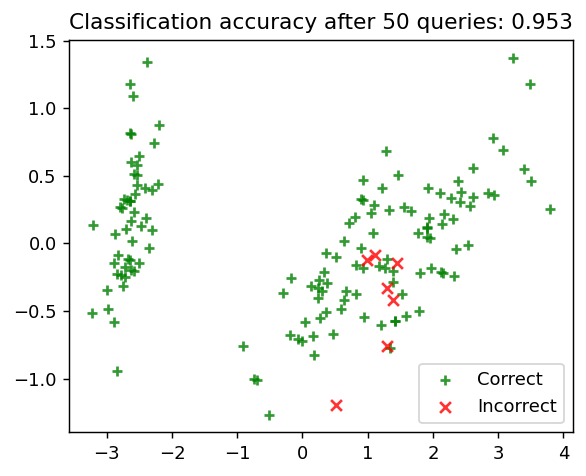

In [11]:
# Isolate the data we'll need for plotting.
predictions = learner.predict(X_raw)
print(predictions)
is_correct = (predictions == y_raw)

# Plot our updated classification results once we've trained our learner.
fig, ax = plt.subplots(figsize=(5,4), dpi=130)

ax.scatter(x=x_component[is_correct],  y=y_component[is_correct],  c='g', marker='+', label='Correct',   alpha=8/10)
ax.scatter(x=x_component[~is_correct], y=y_component[~is_correct], c='r', marker='x', label='Incorrect', alpha=8/10)

ax.set_title('Classification accuracy after {n} queries: {final_acc:.3f}'.format(n=N_QUERIES, final_acc=performance_history[-1]))
ax.legend(loc='lower right')

plt.show()